In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sbi.inference import NPE
from sbi.analysis import pairplot

/Users/tsyamamoto/miniforge3/envs/sbi_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def damped_sinusoid(t, amp, f0, tau, phi):
    return amp * torch.exp(-t / tau) * torch.cos(2.0 * np.pi * f0 * t + phi)

def damped_sinusoid_double(t, amp1, fqnm1, tau1, phi1, amp2, fqnm2, tau2, phi2):
    signal1 = damped_sinusoid(t, amp1, fqnm1, tau1, phi1)
    signal2 = damped_sinusoid(t, amp2, fqnm2, tau2, phi2)
    return signal1 + signal2

def simulator(signal, noisevar):
    return signal + torch.randn_like(signal) * np.sqrt(noisevar)

In [3]:
def ordering(x, y):
    # if x[i] < y[i], swap them
    mask = x < y
    x_tmp = x.copy()
    x[mask] = y[mask]
    y[mask] = x_tmp[mask]
    return x, y

def sample_qnm_parameters(nsample):
    fqnm1 = np.random.uniform(10.0, 20.0, (nsample,))
    fqnm2 = np.random.uniform(10.0, 20.0, (nsample,))
    tau1 = np.random.uniform(0.1, 0.3, (nsample,))
    tau2 = np.random.uniform(0.1, 0.3, (nsample,))

    fqnm1, fqnm2 = ordering(fqnm1, fqnm2)
    tau1, tau2 = ordering(tau1, tau2)
    return fqnm1, fqnm2, tau1, tau2

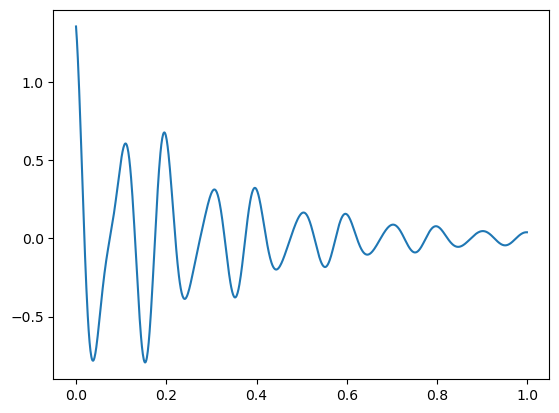

In [4]:
params1 = {
    'amp1': 1.0,
    'fqnm1': 10.0,
    'tau1': 0.3,
    'phi1': 0.0
}

params2 = {
    'amp2': 0.5,
    'fqnm2': 15.0,
    'tau2': 0.2,
    'phi2': np.pi / 4.0
}

params = params1 | params2

n_tsample = 1000
t = torch.arange(n_tsample, dtype=torch.float) / n_tsample
signal = damped_sinusoid_double(t, **params)

plt.figure()
plt.plot(t, signal)
plt.show()

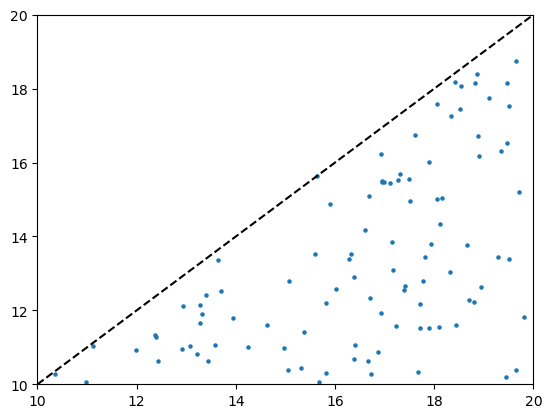

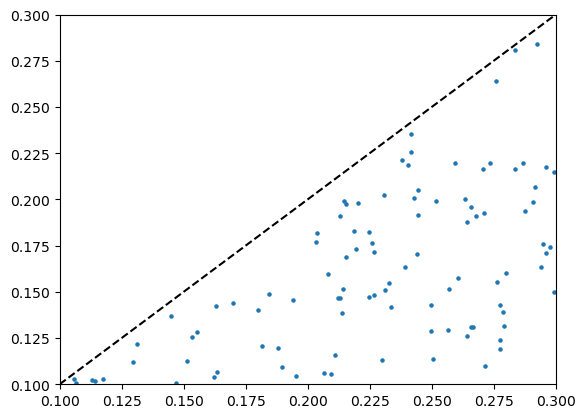

In [5]:
fqnm1, fqnm2, tau1, tau2 = sample_qnm_parameters(100)

plt.figure()
plt.scatter(fqnm1, fqnm2, s=5)
plt.plot(np.linspace(10, 20, 10), np.linspace(10, 20, 10), c='k', linestyle='--')
plt.xlim([10, 20])
plt.ylim([10, 20])

plt.figure()
plt.scatter(tau1, tau2, s=5)
plt.plot(np.linspace(0.1, 0.3, 10), np.linspace(0.1, 0.3, 10), c='k', linestyle='--')
plt.xlim([0.1, 0.3])
plt.ylim([0.1, 0.3])

plt.show()

In [6]:
n_trainsample = 10000
train_x = torch.zeros((n_trainsample, n_tsample), dtype=torch.float)
train_theta = torch.zeros((n_trainsample, 4), dtype=torch.float)
fqnm1, fqnm2, tau1, tau2 = sample_qnm_parameters(n_trainsample)
for j in range(n_trainsample):
    params = {
        'amp1': 1.0,
        'fqnm1': fqnm1[j],
        'tau1': tau1[j],
        'phi1': 0.0,
        'amp2': 0.5,
        'fqnm2': fqnm2[j],
        'tau2': tau2[j],
        'phi2': np.pi / 4.0
    }
    train_theta[j, 0] = params['fqnm1']
    train_theta[j, 1] = params['fqnm2']
    train_theta[j, 2] = params['tau1']
    train_theta[j, 3] = params['tau2']
    signal = damped_sinusoid_double(t, **params)
    train_x[j] = simulator(signal, 0.01)

In [7]:
# choose sbi method and train
inference = NPE()
inference.append_simulations(train_theta, train_x).train();

 Neural network successfully converged after 28 epochs.

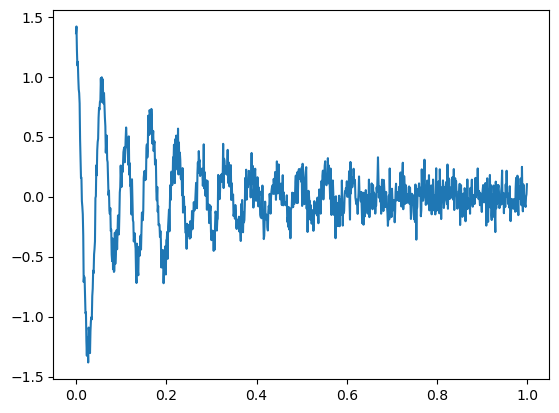

In [8]:
# Test data
params = {
    'amp1': 1.0,
    'fqnm1': 18.0,
    'tau1': 0.25,
    'phi1': 0.0,
    'amp2': 0.5,
    'fqnm2': 12.0,
    'tau2': 0.13,
    'phi2': np.pi / 4
}
signal = damped_sinusoid_double(t, **params)
observation = simulator(signal, 0.01)

plt.figure()
plt.plot(t, observation)
plt.show()

In [9]:
ndraw = 10000
posterior = inference.build_posterior()
samples = posterior.sample((ndraw,), x=observation)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 52724.25it/s]


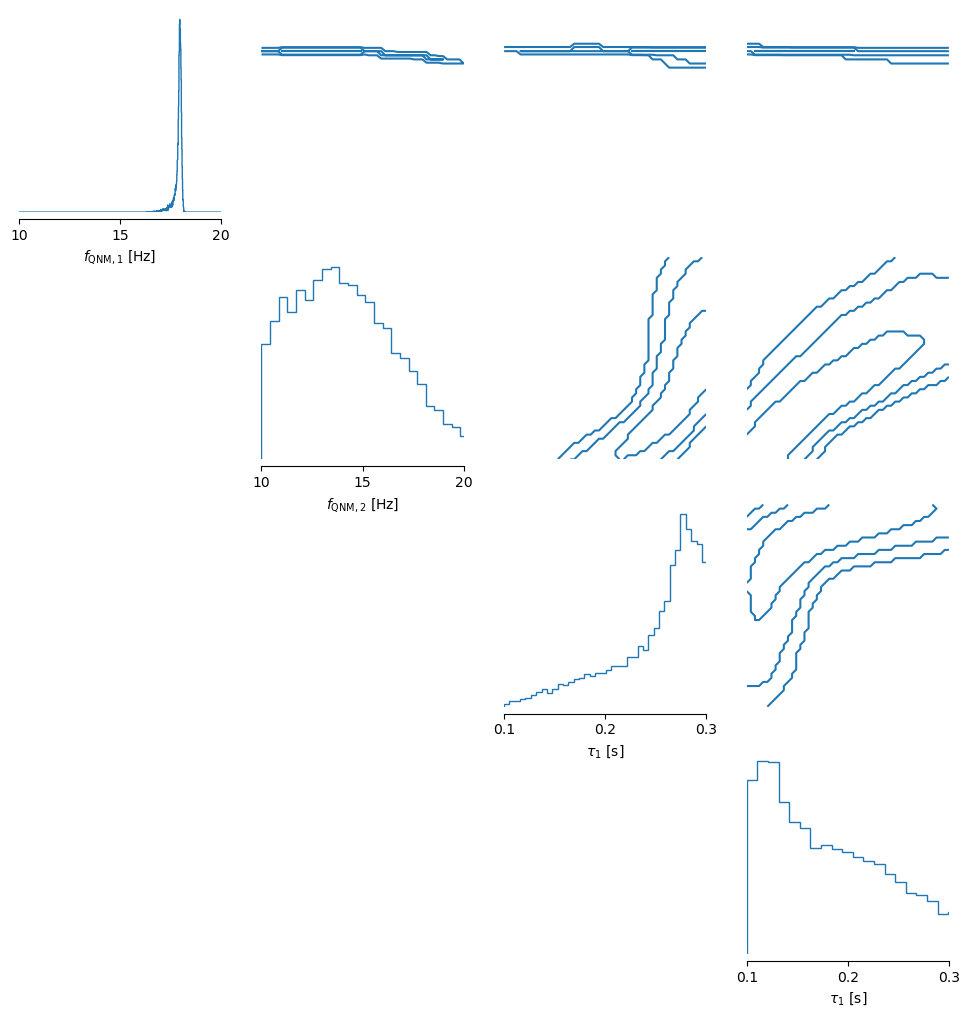

In [10]:
pairplot(
    samples,
    figsize=(12, 12),
    limits=[[10, 20], [10, 20], [0.1, 0.3], [0.1, 0.3]],
    upper="contour",
    labels=[r"$f_\mathrm{QNM,1}$ [Hz]", r"$f_\mathrm{QNM,2}$ [Hz]", r"$\tau_1$ [s]", r"$\tau_1$ [s]"],
    # colors=['blue', 'orange']
);